In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
import pyarrow as pa
import pyarrow.parquet as pq

In [3]:
train = pd.read_parquet('/content/drive/MyDrive/corca/train.parquet')

In [4]:
x_all = pd.read_parquet('/content/drive/MyDrive/corca/data.parquet')

In [5]:
x_all = x_all.drop('date', axis =1)

In [6]:
x_all = x_all.drop('id', axis =1)

In [7]:
y_train =  train['click']

In [17]:
y_train.sum()/len(y_train)

0.1698667791732506

In [8]:
import lightgbm
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report

In [9]:
# extract exam data from pre-processed combined data
def split_train_exam(X_combined, n):
    X_task = X_combined.iloc[:n,:]
    X_exam = X_combined.iloc[n:,:]
    return X_task, X_exam

In [10]:
def model_perf(model, X, Y, prefix=''):
    Yhat = model.predict(X)
    Yprob = model.predict_proba(X)[:,1]
    auc_score = roc_auc_score(Y, Yprob)
    print(f'{prefix} auc score = {auc_score:.3f}')

    #print(f"{prefix} Classfication report:")
    #print(classification_report(Y, Yhat))

def model_fit_perf(model, X_all, Y_all, prefix=''):
    X_trn, X_val, Y_trn, Y_val = train_test_split(X_all, Y_all, test_size=0.2, random_state=0)
    model.fit(X_trn, Y_trn)
    print (prefix)
    model_perf(model, X_trn, Y_trn, '  Training  ')
    #model_perf(model, X_val, Y_val, '  Validation')

In [11]:
X_task, X_exam = split_train_exam(x_all, train.shape[0])

In [12]:
%pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 409.6/409.6 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.8/226.8 kB 29.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 11.3 MB/s eta 0:00:00


In [12]:
import numpy as np
import pandas as pd
import optuna
from lightgbm import LGBMClassifier
from optuna import Trial
from optuna.samplers import TPESampler
from sklearn.metrics import log_loss
from sklearn.model_selection import train_test_split

In [15]:
h_train_X, h_valid_X, h_train_y, h_valid_y = train_test_split(X_task, y_train, test_size=0.2, random_state=0)

In [25]:
sampler = TPESampler(seed=10)

def objective(trial):
    dtrain = lightgbm.Dataset(h_train_X, label=h_train_y)
    dtest = lightgbm.Dataset(h_valid_X, label=h_valid_y)

    param = {
        'objective': 'binary',
        'verbose': -1,
        'metric': 'auc',
        'max_depth': trial.suggest_int('max_depth',3, 15),
        'learning_rate': trial.suggest_loguniform("learning_rate", 1e-8, 1e-2),
        'n_estimators': trial.suggest_int('n_estimators', 100, 3000),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'subsample': trial.suggest_loguniform('subsample', 0.4, 1),
        'early_stopping_rounds' : 25,
        'verbose' : -1
    }

    model = lightgbm.LGBMClassifier(**param)
    lgb_model = model.fit(h_train_X, h_train_y, eval_set=[(h_valid_X, h_valid_y)])#, early_stopping_rounds=25)
    lgb_pred = lgb_model.predict_proba(h_valid_X)[:,1]
    log_score = log_loss(h_valid_y, lgb_pred)
    return log_score

study_lgb = optuna.create_study(direction='minimize', sampler=sampler)
study_lgb.optimize(objective, n_trials=100)

[I 2023-11-17 08:19:58,137] A new study created in memory with name: no-name-d0ef6e4b-a70b-4b41-a6fd-154c6658ff7b
<ipython-input-25-fe64e1bcabe2>:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform("learning_rate", 1e-8, 1e-2),
<ipython-input-25-fe64e1bcabe2>:15: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'subsample': trial.suggest_loguniform('subsample', 0.4, 1),
[I 2023-11-17 08:21:09,204] Trial 0 finished with value: 0.4560831355901282 and parameters: {'max_depth': 13, 'learning_rate': 1.3320229150659043e-08, 'n_estimators': 1938, 'min_child_samples': 76, 'subsample': 0.6315909175774905}. Best is trial 0 with value: 0.456083

KeyboardInterrupt: ignored

In [13]:
param = {
        'objective': 'binary',
        'verbose': -1,
        'metric': 'auc',
        'max_depth':9,
        'learning_rate': 0.0028621284175223464,
        'n_estimators': 944,
        'min_child_samples':58,
        'subsample': 0.905544026431029
    }

lgbmodel = lightgbm.LGBMClassifier(**param)
model_fit_perf(lgbmodel, X_task, y_train,"LGBM")

LGBM
  Training   auc score = 0.722


In [14]:
#submisson = pd.read_csv('/content/drive/MyDrive/corca/sample_submission.csv')

#submisson['click'] = lgbmodel.predict_proba(X_exam)[:,1]
#submisson.to_csv('/content/drive/MyDrive/corca/1100_submission.csv',sep = ',', na_rep= 'Nan', index = False)

# final model(simple one is better)

In [16]:
X_test, X_val, y_test, y_val = train_test_split(X_task, y_train, test_size=0.5, random_state=42)

In [17]:
lgb_clf = lightgbm.LGBMClassifier(num_leaves=31, objective='binary')
lgb_clf.fit(X_test, y_test)
y_pred = lgb_clf.predict(X_val)

[LightGBM] [Info] Number of positive: 3073687, number of negative: 15031327
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.372911 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2379
[LightGBM] [Info] Number of data points in the train set: 18105014, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.169770 -> initscore=-1.587259
[LightGBM] [Info] Start training from score -1.587259


In [18]:
roc_auc_score(y_val, lgb_clf.predict_proba(X_val)[:,1])

0.7380169962395241

In [22]:
lgb_clf2 = lightgbm.LGBMClassifier(num_leaves=31, objective='binary',metric='auc', class_weight={0:1, 1:5.25})
lgb_clf2.fit(X_test, y_test)
y_pred = lgb_clf2.predict(X_val)

[LightGBM] [Info] Number of positive: 3073687, number of negative: 15031327
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.125555 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2379
[LightGBM] [Info] Number of data points in the train set: 18105014, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.517735 -> initscore=0.070969
[LightGBM] [Info] Start training from score 0.070969


In [23]:
roc_auc_score(y_val, lgb_clf2.predict_proba(X_val)[:,1]) #유의미한 차이 없음

0.7375388052135111

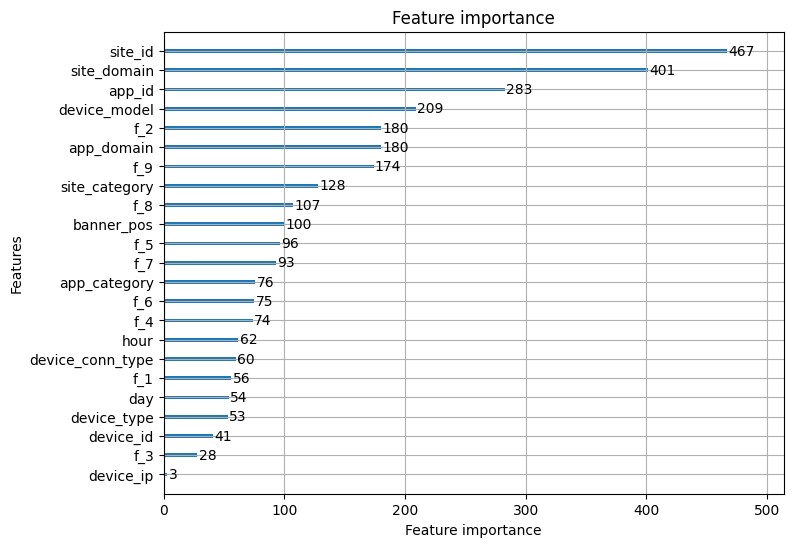

In [25]:
from lightgbm import plot_importance
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8,6))
plot_importance(lgb_clf, ax = ax)
plt.show()

In [26]:
submisson = pd.read_csv('/content/drive/MyDrive/corca/sample_submission.csv')

submisson['click'] = lgb_clf.predict_proba(X_exam)[:,1]
submisson.to_csv('/content/drive/MyDrive/corca/final_submission.csv',sep = ',', na_rep= 'Nan', index = False)